#**Intro**

In questo progetto si andranno ad addestrare e valutare alcuni classificatori per il riconoscimento di immagini. In particolare si utilizzerà un dataset MNIST-like contente le lettere dell'alfabeto e il nostro obiettivo sarà riconoscere la lettera contenuta all'interno dell'immagine.

I classificatori che verrano utilizzati sono:


*   K-Nearest Neighbors
*   Random Forests
*   Basic NN (una NN molto semplice)
*   Le-Net
*   My CNN (una CNN fatta da me)



**N.B.** Non ci sono distinzioni tra lettere maiuscole o minuscole e per il caricamento del dataset è necessario avere il file csv caricato nel proprio repository di Google Drive

# **Import e settaggio del dataset**

Qui di seguito ci sono i vari import

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/emnist-letters.csv'

df = pd.read_csv(path)
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order="F")
y = df.iloc[:,0].to_numpy()-1

import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import preprocess_input
from keras import datasets, layers, models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

import matplotlib.pyplot as plt

import numpy as np
import os
import imageio
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

modelsName = []
accList = []

Mounted at /content/gdrive


Suddivido X nei vari set, cioè train, validation e test set

In [ ]:
#Mi credo la parte di train e test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Divido train_full in train e validation set.
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42)
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

#Setto X in modo adeguato per i classificatori KNN e Random Forest
X_train_Class = X_train.reshape((X_train.shape[0], -1))
X_test_Class = X_test.reshape((X_test.shape[0], -1))
X_valid_Class = X_valid.reshape((X_valid.shape[0], -1))

#Setto X in modo adeguato per le reti neurali convoluzionali
X_train_CNN = X_train.reshape(-1, 28, 28, 1)
X_valid_CNN = X_valid.reshape(-1, 28, 28, 1)
X_test_CNN = X_test.reshape(-1, 28, 28, 1)

Una stampa delle prime immagini del dataset

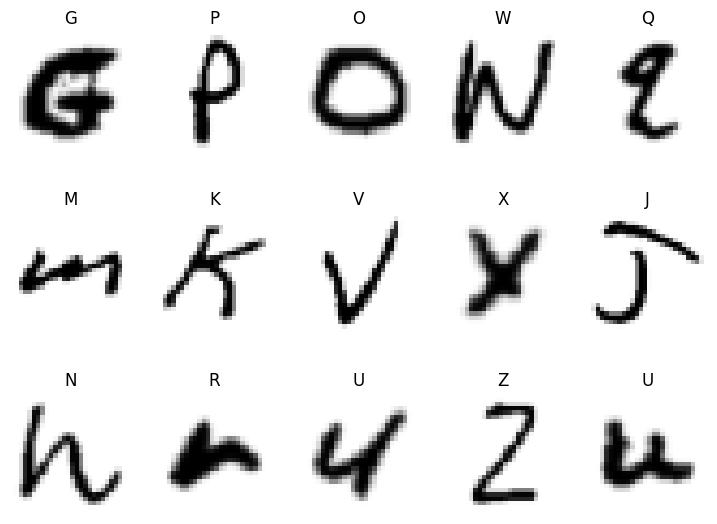

In [ ]:
letters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L","M", "N", "O",
               "P", "Q", "R", "S", "T", "U", "V", "W", "X","Y", "Z"]

plt.figure(figsize=(9, 9))
for i in range(15):
      plt.subplot(4, 5, i + 1)
      plt.imshow(X[i], cmap="binary", interpolation="nearest")
      plt.title(letters[y[i]])
      plt.axis('off')
plt.show()

#**Creazione Funzioni**

Queste tre funzioni sono state implementate per permettere la stampa delle curve di accuracy e loss, delle matrici di confusione e dell'istogramma.

In [ ]:
def show_plot(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show()

In [ ]:
def show_matrix(y_pred, y_test):
  # Calcolo la matrice di confusione
  cm = confusion_matrix(y_test, y_pred)

  # Stampo la matrice di confusione
  fig, ax = plt.subplots(figsize=(14.3, 12))
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=letters)
  disp.plot(ax=ax, cmap=plt.cm.Oranges, values_format=".2f")

  plt.xticks( ha='center', fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel('Predicted', fontsize=15)
  plt.ylabel('True', fontsize=15)
  plt.title('Confusion Matrix', fontsize=18)

  # Aggiungo delle linee di delimitazione tra le celle
  ax.set_xticks(np.arange(cm.shape[1]+1) - 0.5, minor=True)
  ax.set_yticks(np.arange(cm.shape[0]+1) - 0.5, minor=True)
  ax.grid(which='minor', color='black', linestyle='-', linewidth=0.4)
  ax.tick_params(which='minor', size=0)

  plt.show()

In [ ]:
def show_histogram(nameList, dataList, typeData):
  # Creo il grafico a istogramma
  plt.figure(figsize=(10, 6))
  bars = plt.bar(nameList, dataList, color='yellow', alpha=0.7)

  # Si aggiunge il testo sopra le barre
  for bar, score in zip(bars, dataList):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05, f'{score:.2f}',
             ha='center', va='bottom', color='black', fontsize=12)

  # Si aggiungono le etichette e il titolo
  plt.xlabel('Modelli', fontsize=14)
  plt.ylabel(typeData, fontsize=14)
  plt.title('Confronto '+typeData+' tra i Modelli', fontsize=16)
  plt.ylim(0, 1)
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout()
  plt.show()

#**KNN**

Qui si addestra un modello di tipo K-Nearest Neighbors, viene fatta prima una ricerca per trovare il valore ottimale dei k-vicini e poi viene addestrato il modello con il k trovato.

Si fa la search per il miglior iperparametro (questa ricerca è stata commentata poiché la durata è abbastanza lunga e difatti nel modello da addestrare si scrive direttamente il miglior iperparametro trovato)

In [ ]:
#knn = KNeighborsClassifier()

#param_grid = {'n_neighbors': np.arange(1, 16)}  # Esplora valori di k da 1 a 15

#random_search = RandomizedSearchCV(
#    knn,
#    param_distributions=param_grid,
#    n_iter=15,
#    cv=5,
#    scoring='accuracy',
#    n_jobs=-2,
#    random_state=42,
#    verbose=2)

#random_search.fit(X_train_Class, y_train)

# Visualizza i migliori parametri trovati
#print("Miglior iperparametro: ", random_search.best_params_)


Fit del modello

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
historyKnn = knn.fit(X_train_Class, y_train)

Le varie accuracy

In [ ]:
accuracy_train = knn.score(X_train_Class, y_train)
print(f'Accuracy Train Set: {accuracy_train:.4f}')
accuracy_valid = knn.score(X_valid_Class, y_valid)
print(f'Accuracy Validation Set: {accuracy_valid:.4f}')
accuracy_test = knn.score(X_test_Class, y_test)
print(f'Accuracy Test Set: {accuracy_test:.4f}')
modelsName.append('KNN')
accList.append(accuracy_test)

Accuracy Train Set: 0.8912
Accuracy Validation Set: 0.8471
Accuracy Test Set: 0.8407


Matrice di confusione

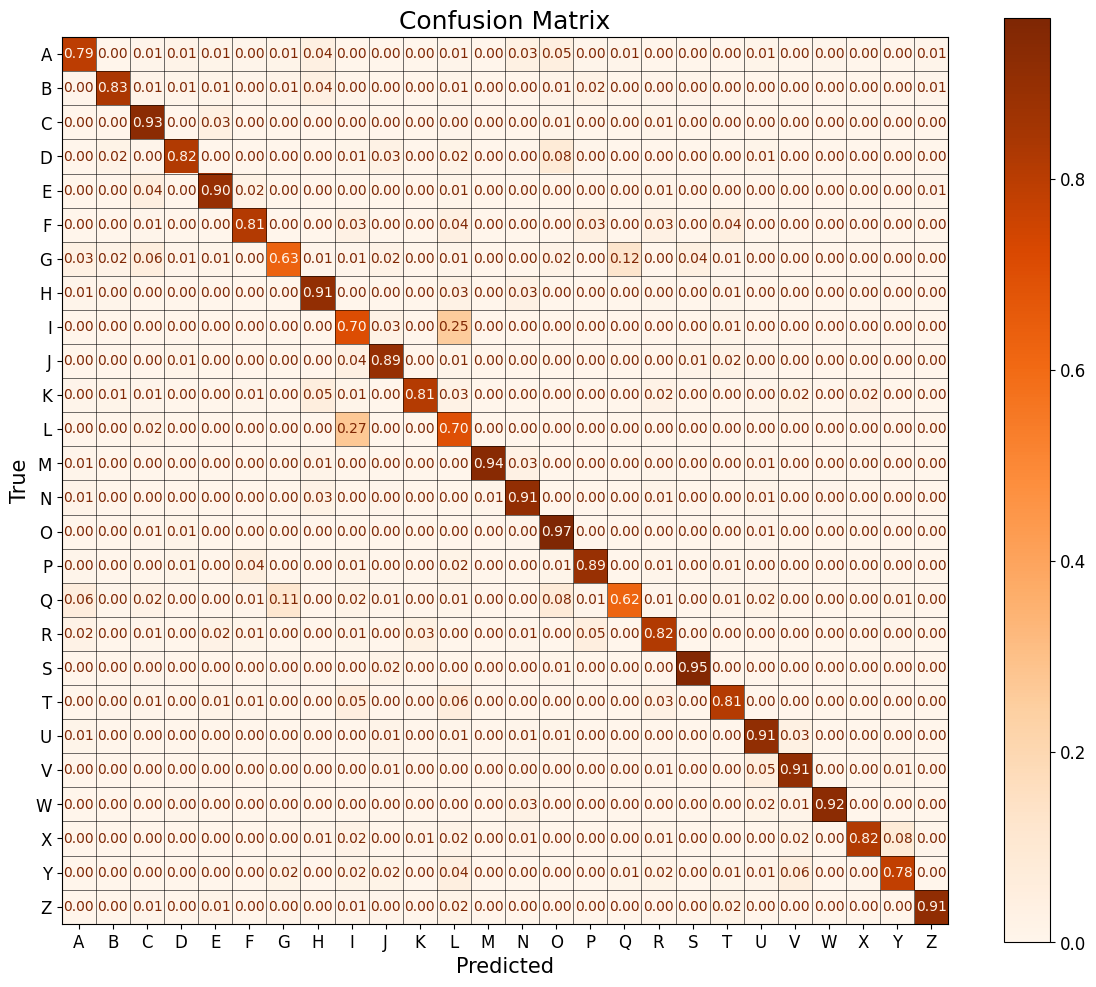

In [ ]:
y_pred = knn.predict(X_test_Class)

show_matrix(y_pred, y_test)

#**Random Forests**

Qui si addestra un modello di tipo Random Forests, viene fatta prima una search per trovare gli iperparametri ottimali di n_estimators, max_depth e min_samples_split, che sono rispettivamente il numero di alberi decisionali, la massima profondità di ciascun albero decisionale e il numero minimo di campioni richiesti per suddividere un nodo.

Una volta trovati gli iperparametri ottimali si fa l'addestramento del modello.

Anche in questo caso la search dei migliori iperparametri è stata commentata poiché la ricerca richiede un po' di tempo.

In [ ]:
#param_grid = {
#    'n_estimators': [50, 100, 150],
#    'max_depth': [None, 15, 30],
#    'min_samples_split': [2, 8, 16],
#}
#random_forest_classifier = RandomForestClassifier(random_state=42)
# Creazione di un oggetto RandomizedSearchCV
#random_search = RandomizedSearchCV(random_forest_classifier, param_grid, n_iter=50, cv=5, scoring='accuracy', random_state=42,verbose=2)
#random_search.fit(X_train_Class, y_train)

#best_params = random_search.best_params_
#print(f'Migliori iperparametri: {best_params}')



Fit del modello

In [ ]:
best_params = {
    'n_estimators': 150,
    'max_depth': None,
    'min_samples_split': 2,
}

# Creazione del classificatore Random Forest con i migliori iperparametri
rfc = RandomForestClassifier( **best_params, random_state=42)
rfc.fit(X_train_Class, y_train)


RandomForestClassifier(n_estimators=150, random_state=42)

Le varie accuracy

In [ ]:
accuracy_train = rfc.score(X_train_Class, y_train)
print(f'Accuracy Train Set: {accuracy_train:.4f}')
accuracy_valid = rfc.score(X_valid_Class, y_valid)
print(f'Accuracy Validation Set: {accuracy_valid:.4f}')
accuracy_test = rfc.score(X_test_Class, y_test)
print(f'Accuracy Test Set: {accuracy_test:.4f}')
accList.append(accuracy_test)
modelsName.append('Random Forests')

Accuracy Train Set: 1.0000
Accuracy Validation Set: 0.8710
Accuracy Test Set: 0.8684


Matrice di confusione

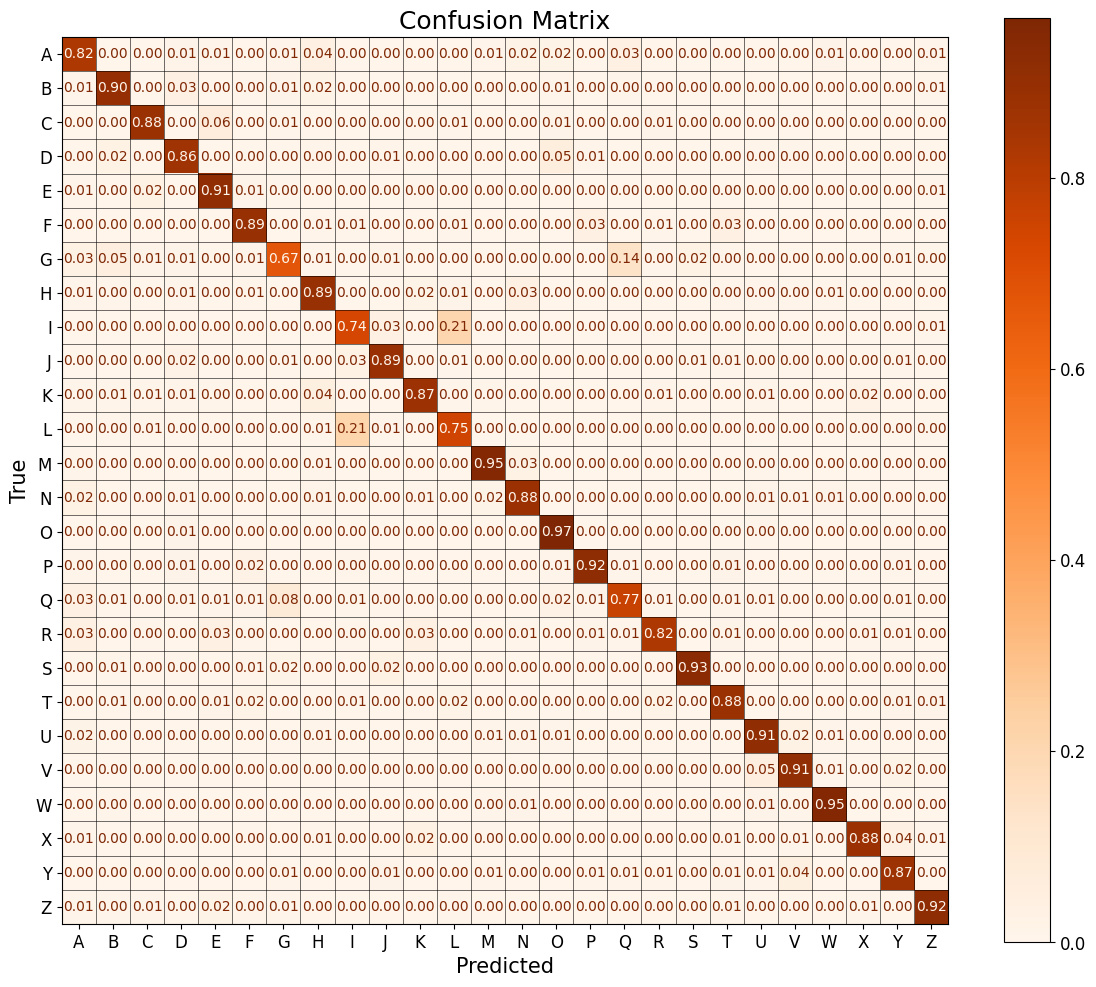

In [ ]:
y_pred = rfc.predict(X_test_Class)

show_matrix(y_pred, y_test)

#**Basic NN**

Prendendo spunto dal codice "tf_fashion.ipynb", condiviso nelle lezioni, è stato deciso di addestrare la sequente NN.
In questa rete neurale viene aggiunto un livello in più rispetto al codice originale e si modifica il numero di neuroni utilizzati.
Si utilizza la relu come funzione di attivazione negli hidden layers e come funzione di attivazione nel layer di output si utilizza la softmax.

Come funzione di perdita si usa la "sparse_categorical_crossentropy" e come ottimizzatore SGD.


Costruzione del modello

In [ ]:
basic = keras.models.Sequential()
basic.add(keras.layers.Flatten(input_shape=[28, 28]))
basic.add(keras.layers.Dense(150, activation="relu"))
basic.add(keras.layers.Dense(100, activation="relu"))
basic.add(keras.layers.Dense(50, activation="relu"))
basic.add(keras.layers.Dense(26, activation="softmax"))
basic.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])


Fit del modello

In [ ]:
history = basic.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
1887/1887 [==============================] - 9s 3ms/step - loss: 1.8029 - accuracy: 0.4957 - val_loss: 1.1581 - val_accuracy: 0.6670
Epoch 2/50
1887/1887 [==============================] - 7s 4ms/step - loss: 0.9929 - accuracy: 0.7062 - val_loss: 0.8857 - val_accuracy: 0.7422
Epoch 3/50
1887/1887 [==============================] - 6s 3ms/step - loss: 0.7881 - accuracy: 0.7674 - val_loss: 0.7478 - val_accuracy: 0.7822
Epoch 4/50
1887/1887 [==============================] - 7s 4ms/step - loss: 0.6603 - accuracy: 0.8046 - val_loss: 0.6435 - val_accuracy: 0.8131
Epoch 5/50
1887/1887 [==============================] - 6s 3ms/step - loss: 0.5746 - accuracy: 0.8283 - val_loss: 0.5858 - val_accuracy: 0.8260
Epoch 6/50
1887/1887 [==============================] - 7s 4ms/step - loss: 0.5144 - accuracy: 0.8447 - val_loss: 0.5289 - val_accuracy: 0.8424
Epoch 7/50
1887/1887 [==============================] - 6s 3ms/step - loss: 0.4694 - accuracy: 0.8568 - val_loss: 0.4994 - val_accuracy:

Le varie accuracy

In [ ]:
accuracy_train = basic.evaluate(X_train, y_train)
print(f'Accuracy Train Set: {(accuracy_train[1]):.4f}')
accuracy_valid = basic.evaluate(X_valid, y_valid)
print(f'Accuracy Validation Set: {(accuracy_valid[1]):.4f}')
accuracy_test = basic.evaluate(X_test, y_test)
print(f'Accuracy Test Set: {(accuracy_test[1]):.4f}')
accList.append(accuracy_test[1])
modelsName.append('Basic NN')

1887/1887 [==============================] - 4s 2ms/step - loss: 0.0965 - accuracy: 0.9670
Accuracy Train Set: 0.9670
333/333 [==============================] - 1s 2ms/step - loss: 0.4428 - accuracy: 0.8862
Accuracy Validation Set: 0.8862
555/555 [==============================] - 1s 2ms/step - loss: 0.4474 - accuracy: 0.8793
Accuracy Test Set: 0.8793


Curve di loss e accuracy

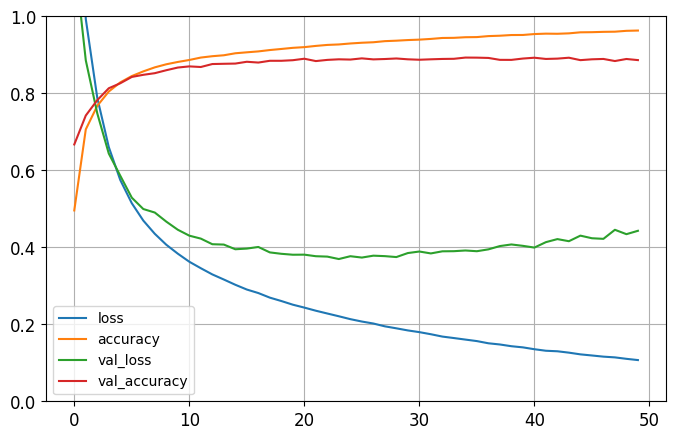

In [ ]:
show_plot(history)

Matrice di confusione

555/555 [==============================] - 1s 2ms/step


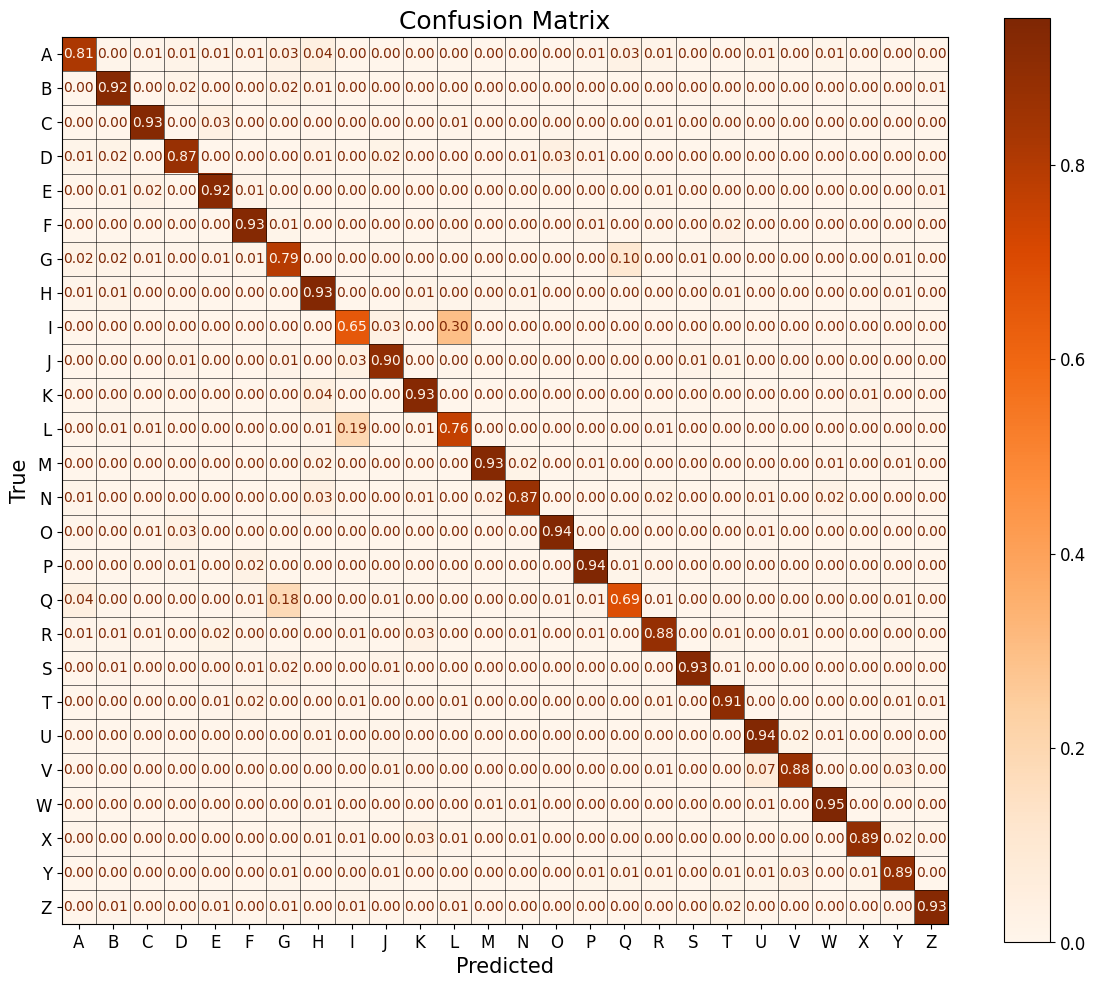

In [ ]:
y_pred = basic.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

show_matrix(y_pred_classes, y_test)

#**Le-Net**

Qui si utilizza la CNN Le-Net, è stato deciso di utilizzarla poiché è una delle prime CNN pubblicate. Per implementarla è stato usato il codice fornito durante il corso.

Costruzione del modello Le-Net

In [ ]:
lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='sigmoid'),
            tf.keras.layers.Dense(84, activation='sigmoid'),
            tf.keras.layers.Dense(26, activation="softmax")])


lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 120)              

Fit del modello

In [ ]:
history2 = lenet.fit(X_train_CNN, y_train, epochs=50,
                    validation_data=(X_valid_CNN, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Epoch 1/50
1887/1887 [==============================] - 12s 5ms/step - loss: 1.8897 - accuracy: 0.4633 - val_loss: 0.9860 - val_accuracy: 0.7125
Epoch 2/50
1887/1887 [==============================] - 8s 4ms/step - loss: 0.7569 - accuracy: 0.7765 - val_loss: 0.6015 - val_accuracy: 0.8195
Epoch 3/50
1887/1887 [==============================] - 8s 4ms/step - loss: 0.5104 - accuracy: 0.8458 - val_loss: 0.4682 - val_accuracy: 0.8571
Epoch 4/50
1887/1887 [==============================] - 7s 4ms/step - loss: 0.4058 - accuracy: 0.8741 - val_loss: 0.3955 - val_accuracy: 0.8789
Epoch 5/50
1887/1887 [==============================] - 9s 5ms/step - loss: 0.3453 - accuracy: 0.8921 - val_loss: 0.3524 - val_accuracy: 0.8897
Epoch 6/50
1887/1887 [==============================] - 8s 4ms/step - loss: 0.3080 - accuracy: 0.9006 - val_loss: 0.3259 - val_accuracy: 0.8984
Epoch 7/50
1887/1887 [==============================] - 8s 4ms/step - loss: 0.2813 - accuracy: 0.9089 - val_loss: 0.2996 - val_accuracy

Le varie accuracy

In [ ]:
accuracy_train = lenet.evaluate(X_train_CNN, y_train)
print(f'Accuracy Train Set: {(accuracy_train[1]):.4f}')
accuracy_valid = lenet.evaluate(X_valid_CNN, y_valid)
print(f'Accuracy Validation Set: {(accuracy_valid[1]):.4f}')
accuracy_test = lenet.evaluate(X_test_CNN, y_test)
print(f'Accuracy Test Set: {(accuracy_test[1]):.4f}')
accList.append(accuracy_test[1])
modelsName.append('Le-Net')

1887/1887 [==============================] - 5s 3ms/step - loss: 0.0809 - accuracy: 0.9686
Accuracy Train Set: 0.9686
333/333 [==============================] - 1s 3ms/step - loss: 0.2802 - accuracy: 0.9227
Accuracy Validation Set: 0.9227
555/555 [==============================] - 1s 2ms/step - loss: 0.2827 - accuracy: 0.9182
Accuracy Test Set: 0.9182


Curve di loss e accuracy

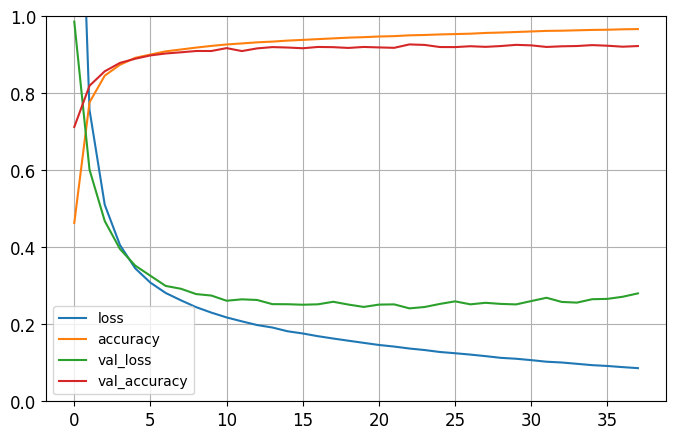

In [ ]:
show_plot(history2)

Matrice di confusione

555/555 [==============================] - 1s 2ms/step


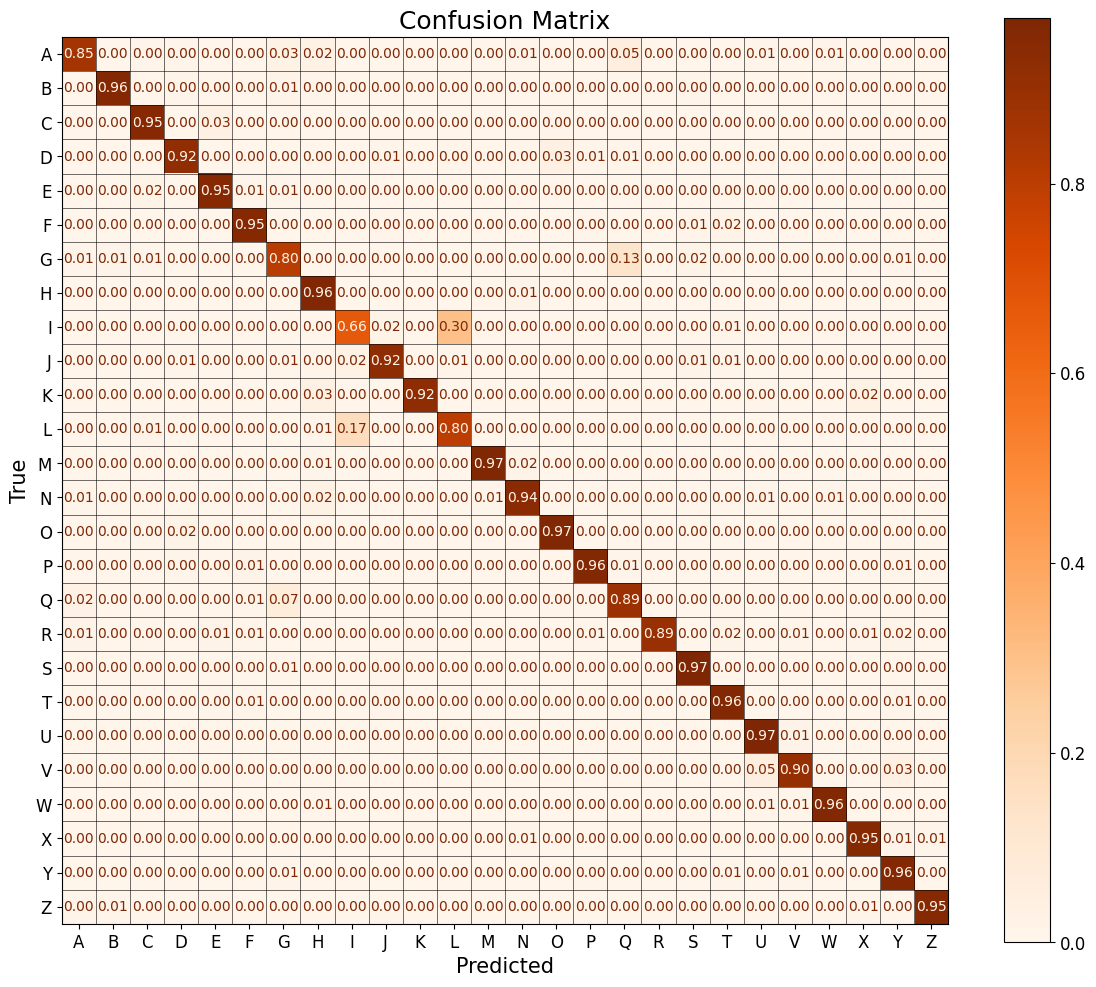

In [ ]:
y_pred = lenet.predict(X_test_CNN)
y_pred_classes = np.argmax(y_pred, axis=1)

show_matrix(y_pred_classes, y_test)


# **My CNN**

Questa CNN è stata implementata da me. L'idea era quello di sfruttare alcuni dei regolarizzatori e ottimizzatori visti durante il corso. Per questo in tutti i livelli (tranne in quello di output) si usa il regolarizzatore l2. Inoltre, i livelli convoluzionali sono seguiti da livelli di pooling con stride, mentre in uno dei due strati densi viene utilizzato il Dropout che è un altro ottimizzatore utile per evitare l'overfitting.

Infine si utilizza un'attivazione softmax per l'output.


Costruzione del modello

In [ ]:
myCnn = keras.models.Sequential()
myCnn.add(layers.Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1),kernel_regularizer=tf.keras.regularizers.l2(0.001)))
myCnn.add(layers.MaxPooling2D((2, 2), strides = 2))
myCnn.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
myCnn.add(layers.MaxPooling2D((3, 3), strides = 3))
myCnn.add(layers.Flatten())
myCnn.add(layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
myCnn.add(layers.Dropout(0.5))
myCnn.add(layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
myCnn.add(layers.Dense(26, activation='softmax'))


In [ ]:
myCnn.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

myCnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 128)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 256)              

Fit del modello

In [ ]:
history3 = myCnn.fit(X_train_CNN, y_train, epochs=50,
                    validation_data=(X_valid_CNN, y_valid),callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
1887/1887 [==============================] - 13s 5ms/step - loss: 1.1222 - accuracy: 0.7389 - val_loss: 0.6192 - val_accuracy: 0.8944
Epoch 2/50
1887/1887 [==============================] - 9s 5ms/step - loss: 0.7547 - accuracy: 0.8473 - val_loss: 0.5531 - val_accuracy: 0.9065
Epoch 3/50
1887/1887 [==============================] - 8s 4ms/step - loss: 0.6684 - accuracy: 0.8676 - val_loss: 0.5180 - val_accuracy: 0.9132
Epoch 4/50
1887/1887 [==============================] - 9s 5ms/step - loss: 0.6211 - accuracy: 0.8777 - val_loss: 0.4910 - val_accuracy: 0.9183
Epoch 5/50
1887/1887 [==============================] - 9s 5ms/step - loss: 0.5867 - accuracy: 0.8859 - val_loss: 0.4760 - val_accuracy: 0.9198
Epoch 6/50
1887/1887 [==============================] - 8s 4ms/step - loss: 0.5688 - accuracy: 0.8887 - val_loss: 0.4725 - val_accuracy: 0.9167
Epoch 7/50
1887/1887 [==============================] - 9s 5ms/step - loss: 0.5553 - accuracy: 0.8920 - val_loss: 0.4545 - val_accuracy

Le varie accuracy

In [ ]:
accuracy_train = myCnn.evaluate(X_train_CNN, y_train)
print(f'Accuracy Train Set: {(accuracy_train[1]):.4f}')
accuracy_valid = myCnn.evaluate(X_valid_CNN, y_valid)
print(f'Accuracy Validation Set: {(accuracy_valid[1]):.4f}')
accuracy_test = myCnn.evaluate(X_test_CNN, y_test)
print(f'Accuracy Test Set: {(accuracy_test[1]):.4f}')
accList.append(accuracy_test[1])
modelsName.append('My CNN')

1887/1887 [==============================] - 5s 3ms/step - loss: 0.3526 - accuracy: 0.9403
Accuracy Train Set: 0.9403
333/333 [==============================] - 1s 2ms/step - loss: 0.3862 - accuracy: 0.9297
Accuracy Validation Set: 0.9297
555/555 [==============================] - 1s 2ms/step - loss: 0.3917 - accuracy: 0.9283
Accuracy Test Set: 0.9283


Curve di loss e accuracy

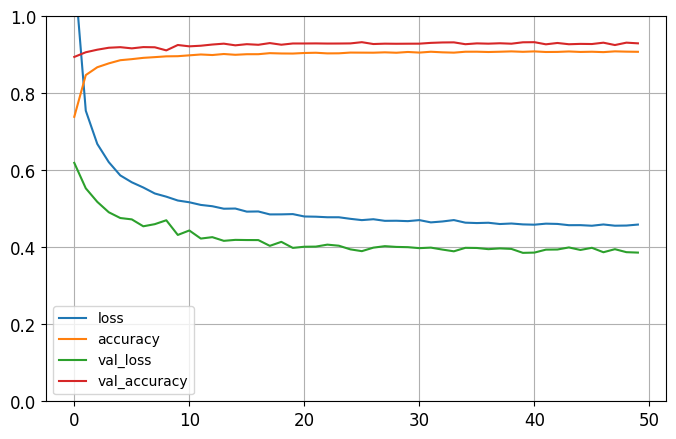

In [ ]:
show_plot(history3)

Matrice di confusione

555/555 [==============================] - 1s 2ms/step


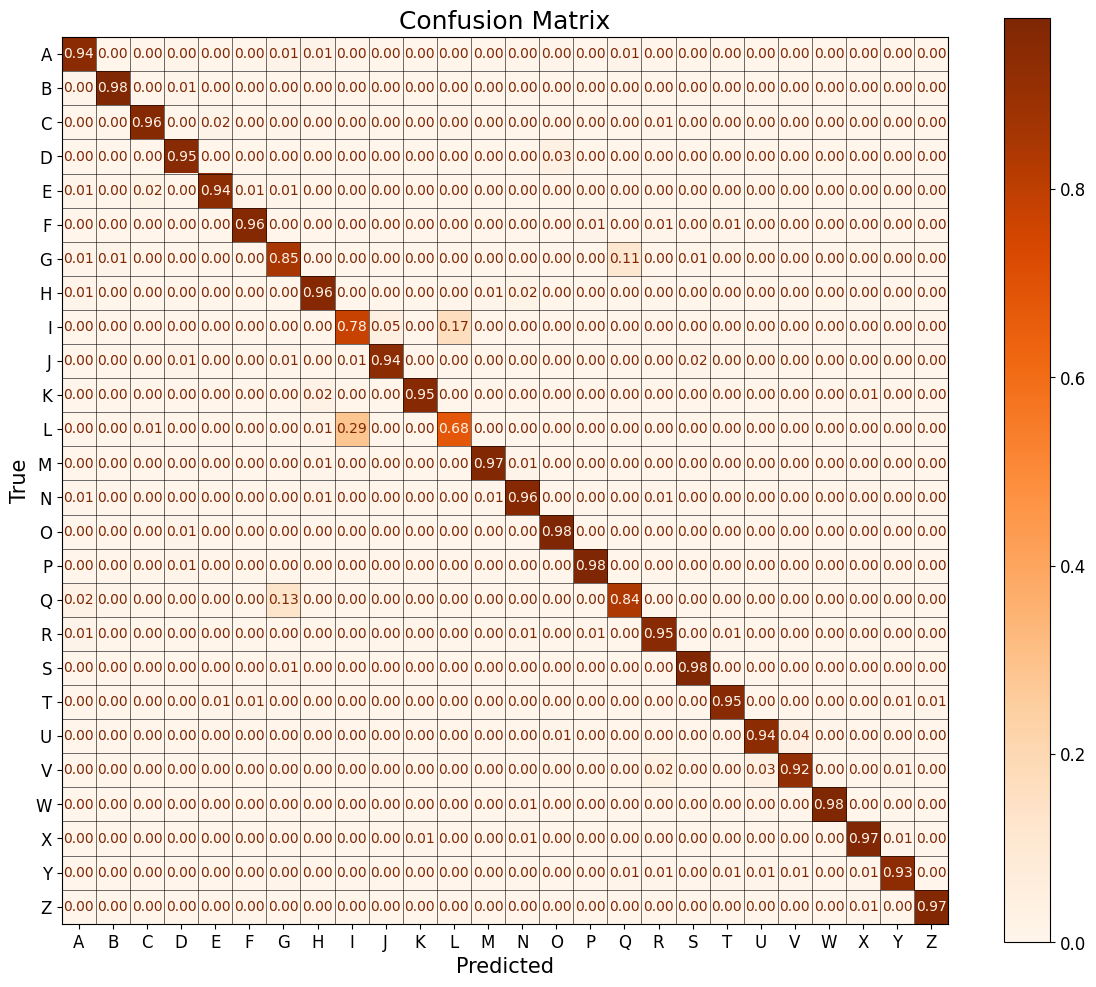

In [ ]:
y_pred = myCnn.predict(X_test_CNN)
y_pred_classes = np.argmax(y_pred, axis=1)

show_matrix(y_pred_classes, y_test)

#**Istogramma**

Qui di seguito c'è un confronto dell'accuracy nel Test Set dei vari classificatori

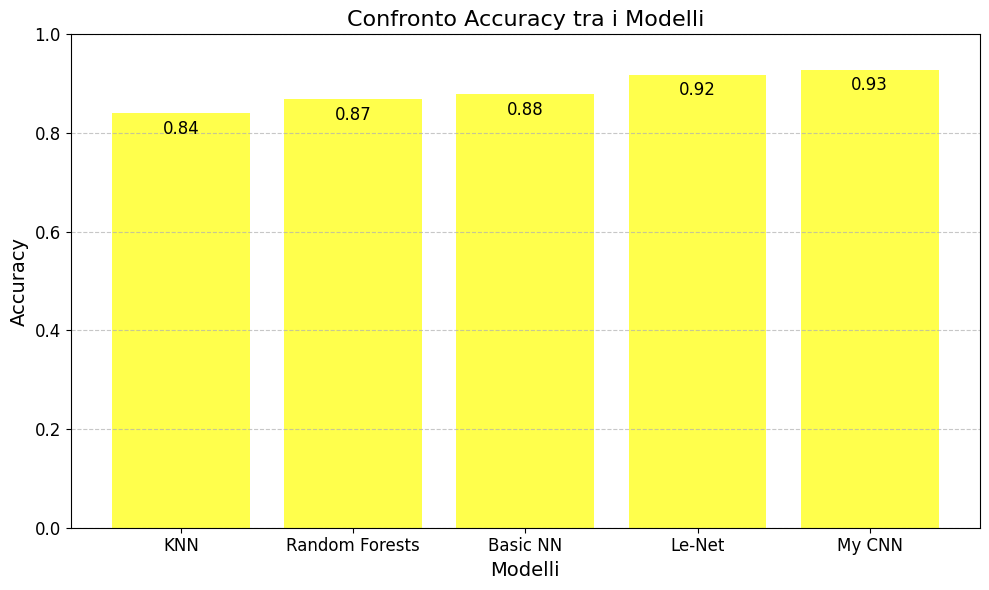

In [ ]:
show_histogram(modelsName, accList, 'Accuracy')

#**Conclusione**

Dai risultati ottenuti si può vedere come ogni modello ha dei buoni valori di accuratezza, ma le prestazioni migliori sono quelle delle reti neurali, in particolare dell'ultima CNN e cioè "My CNN", tra l'altro quest'ultimo classificatore è anche il modello con meno differenza di accuracy tra il training set e gli altri due insiemi (test e validation set).

Anche per quanto riguarda le matrici di confusione viste dopo ogni modello, si può notare come nella maggior parte dei casi le lettere sono riconosciute correttamente ed inoltre è possibile vedere come alcuni caratteri sono più problematici da classificare rispetto ad altri.
Ad esempio la predizione che in ogni modello è la più errata è quella tra la lettera I e la lettera L dove si scambia una per l'altra e viceversa. Un errore che nella realtà può accadere dal momento che la lettera L minuscola è quasi uguale alla I maiuscola.

